In [4]:
import requests
from bs4 import BeautifulSoup


# 2015년부터 2019년까지의 각 연도에 대해 반복
for year in range(2015, 2020):
    # 해당 연도를 이용하여 다음(Daum) 검색 페이지의 URL 생성
    url = "https://search.daum.net/search?w=tot&DA=YZR&t__nil_searchbox=btn&sug=&sugo=&sq=&o=&q={}%EB%85%84+%EC%98%81%ED%99%94%EC%88%9C%EC%9C%84".format(year)
    
    # 생성한 URL로 GET 요청을 보내고 응답을 저장
    res = requests.get(url)
    res.raise_for_status() # 요청이 실패한 경우 프로그램을 중단 (에러처리)
    
    # 요청한 페이지의 HTML 내용을 BeautifulSoup를 이용하여 파싱
    soup = BeautifulSoup(res.text, "lxml")
    
    # "thumb_img" 클래스를 가진 모든 이미지 요소를 찾음
    images = soup.find_all("img", attrs = {"class":"thumb_img"})
    
    # 찾은 이미지들에 대해 반복
    for idx, image in enumerate(images):
        
        # 이미지의 URL을 추출
        image_url = image["src"]
        
        # 이미지 URL이 "//"로 시작하는 경우 "https:"를 추가하여 완전한 URL로 만든다.
        if image_url.startswith("//"):
            image_url = "https:" + image_url
         
        # 이미지 URL을 출력
        # print(image_url)

        # 이미지 URL로 GET요청을 보내고 응답을 저장
        image_res = requests.get(image_url)
        image_res.raise_for_status() # 요청이 실패한 경우 프로그램을 중단
        
        # 이미지 내용을 연도와 인덱스를 포함한 파일 이름으로 저장
        with open("movie_{}_{}.jpg".format(year, idx+1), "wb") as f: # wb(write binary) - 비정형데이터 처리할때 사용
            f.write(image_res.content)
            
        # 상위 5개 이미지만 다운로드하고 반복을 종료
        if idx == 4: # 0 ~ 4 (5개)
            break

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.neighbors  import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
from pandas.plotting import scatter_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestRegressor

In [9]:
# csv 업로드 'Admission_Predict_Ver1.1.csv'

data_predict=pd.read_csv('Admission_Predict_Ver1.1.csv')

data_predict.head(10) # 앞에서 10개 - 비워두면 5개 출력
data_predict.tail(10) # 뒤에서 10개

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
490,491,307,105,2,2.5,4.5,8.12,1,0.67
491,492,297,99,4,3.0,3.5,7.81,0,0.54
492,493,298,101,4,2.5,4.5,7.69,1,0.53
493,494,300,95,2,3.0,1.5,8.22,1,0.62
494,495,301,99,3,2.5,2.0,8.45,1,0.68
495,496,332,108,5,4.5,4.0,9.02,1,0.87
496,497,337,117,5,5.0,5.0,9.87,1,0.96
497,498,330,120,5,4.5,5.0,9.56,1,0.93
498,499,312,103,4,4.0,5.0,8.43,0,0.73
499,500,327,113,4,4.5,4.5,9.04,0,0.84


In [11]:
# 비어있는 데이터 있는지
data_predict.isnull().values.any()
data_predict.isnull().sum() # 컬럼별로 펑크난 데이터가 몇개인지 보여줌

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

# 상관계수

# 두변수간에 어느정도 연관성이 있는지?

In [14]:
# 상관계수 분석함. 학생 일련번호를 분석에서 빼고자 한다면?

data_predict=data_predict.drop(['Serial No.'],axis=1) # 학생번호는 상관관계 없어서 제외  # axis=1 세로 열 하나 삭제 - 0인경우 가로
data_predict.corr() # corr = correlation

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
GRE Score,1.000000,0.827200,0.635376,0.613498,0.524679,0.825878,0.563398,0.810351
TOEFL Score,0.827200,1.000000,0.649799,0.644410,0.541563,0.810574,0.467012,0.792228
University Rating,0.635376,0.649799,1.000000,0.728024,0.608651,0.705254,0.427047,0.690132
SOP,0.613498,0.644410,0.728024,1.000000,0.663707,0.712154,0.408116,0.684137
LOR,0.524679,0.541563,0.608651,0.663707,1.000000,0.637469,0.372526,0.645365
CGPA,0.825878,0.810574,0.705254,0.712154,0.637469,1.000000,0.501311,0.882413
Research,0.563398,0.467012,0.427047,0.408116,0.372526,0.501311,1.000000,0.545871
Chance of Admit,0.810351,0.792228,0.690132,0.684137,0.645365,0.882413,0.545871,1.000000


In [15]:
# chance of admit (y값) 빼고 상관관계 분석

data_predict.iloc[:,:6].corr()  # iloc[행개수, 열개수] - [:,:6] - 행전체, 열 0~5

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA
GRE Score,1.000000,0.827200,0.635376,0.613498,0.524679,0.825878
TOEFL Score,0.827200,1.000000,0.649799,0.644410,0.541563,0.810574
University Rating,0.635376,0.649799,1.000000,0.728024,0.608651,0.705254
SOP,0.613498,0.644410,0.728024,1.000000,0.663707,0.712154
LOR,0.524679,0.541563,0.608651,0.663707,1.000000,0.637469
CGPA,0.825878,0.810574,0.705254,0.712154,0.637469,1.000000


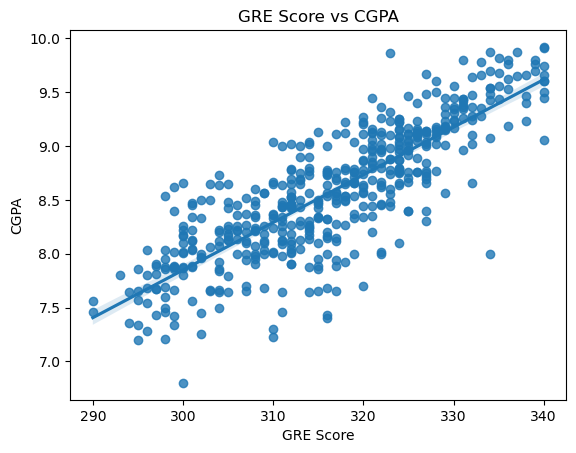

In [16]:
# 그래프 분석하기

fig = sns.regplot(x='GRE Score', y="CGPA", data=data_predict)
plt.title("GRE Score vs CGPA")
plt.show()

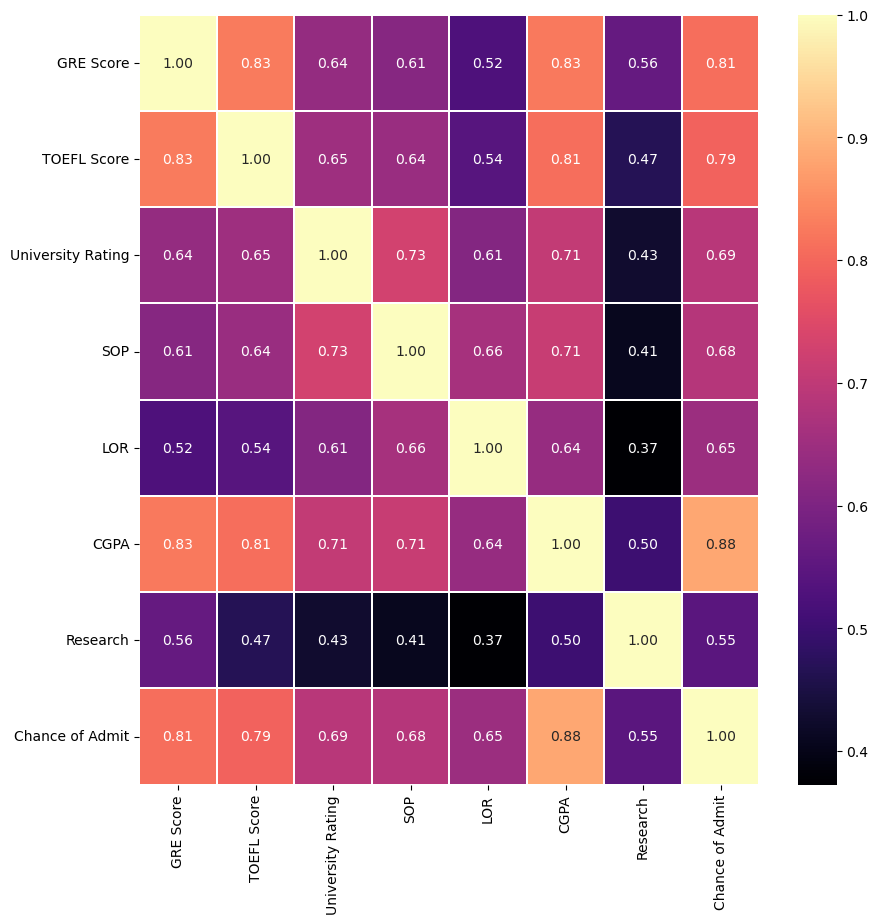

In [17]:
plt.figure(figsize=(10, 10)) # 도표 사이즈
sns.heatmap(data_predict.corr(), annot=True, linewidths=0.05, fmt='.2f', cmap="magma") # 히트맵 사용
plt.show()

In [18]:
# 학점 기준 상위 20명 추려서 보여주기

df_sort_group_top20 = data_predict.sort_values(by="CGPA", ascending=False).head(20) # ascending=False - 내림차순
df_sort_group_top20

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
143,340,120,4,4.5,4.0,9.92,1,0.97
202,340,120,5,4.5,4.5,9.91,1,0.97
496,337,117,5,5.0,5.0,9.87,1,0.96
203,334,120,5,4.0,5.0,9.87,1,0.97
425,323,111,5,4.0,5.0,9.86,1,0.92
385,335,117,5,5.0,5.0,9.82,1,0.96
148,339,116,4,4.0,3.5,9.80,1,0.96
34,331,112,5,4.0,5.0,9.80,1,0.94
24,336,119,5,4.0,3.5,9.80,1,0.97
213,333,119,5,5.0,4.5,9.78,1,0.96


In [19]:
# 학점 기준 하위 20명

df_sort_group_bottom20 = data_predict.sort_values(by="CGPA", ascending=True).head(20) # ascending=False - 내림차순
df_sort_group_bottom20


,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
58,300,99,1,3.0,2.0,6.80,1,0.36
28,295,93,1,2.0,2.0,7.20,0,0.46
464,298,97,2,2.0,3.0,7.21,0,0.45
436,310,110,1,1.5,4.0,7.23,1,0.58
348,302,99,1,2.0,2.0,7.25,0,0.57
118,296,99,2,3.0,3.5,7.28,0,0.47
29,310,99,2,1.5,2.0,7.30,0,0.54
347,299,94,1,1.0,1.0,7.34,0,0.42
344,295,96,2,1.5,2.0,7.34,0,0.47
79,294,93,1,1.5,2.0,7.36,0,0.46


In [21]:
df_sort_group_bottom20_2 = data_predict.sort_values(by="CGPA", ascending=False).tail(20) # ascending=False - 내림차순
df_sort_group_bottom20_2

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
27,298,98,2,1.5,2.5,7.50,1,0.44
38,304,105,1,3.0,1.5,7.50,0,0.52
161,298,99,1,1.5,3.0,7.46,0,0.53
367,311,98,1,1.0,2.5,7.46,0,0.57
117,290,104,4,2.0,2.5,7.46,0,0.45
405,302,99,3,2.5,3.0,7.45,0,0.52
345,316,98,1,1.5,2.0,7.43,0,0.49
376,297,96,2,2.5,2.0,7.43,0,0.34
420,299,100,3,2.0,3.0,7.42,0,0.42
56,316,102,3,2.0,3.0,7.40,0,0.64


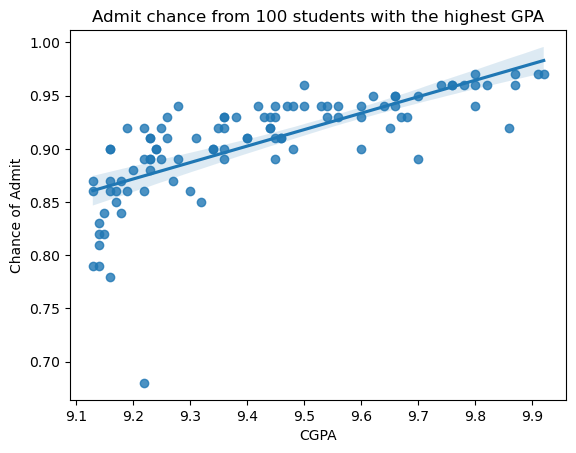

In [22]:
# sns 플롯을 사용해서 아래와 같이 만들기 (학점 상위 100명)

fig = sns.regplot(x="CGPA", y="Chance of Admit", data=data_predict.sort_values(by="CGPA", ascending=False).head(100))
plt.title("Admit chance from 100 students with the highest GPA")
plt.show()

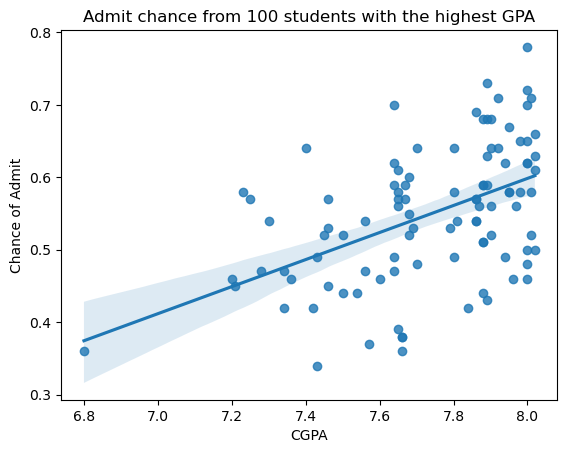

In [23]:
# sns 플롯을 사용해서 아래와 같이 만들기 (학점 하위 100명)

fig = sns.regplot(x="CGPA", y="Chance of Admit", data=data_predict.sort_values(by="CGPA", ascending=False).tail(100))
plt.title("Admit chance from 100 students with the highest GPA")
plt.show()

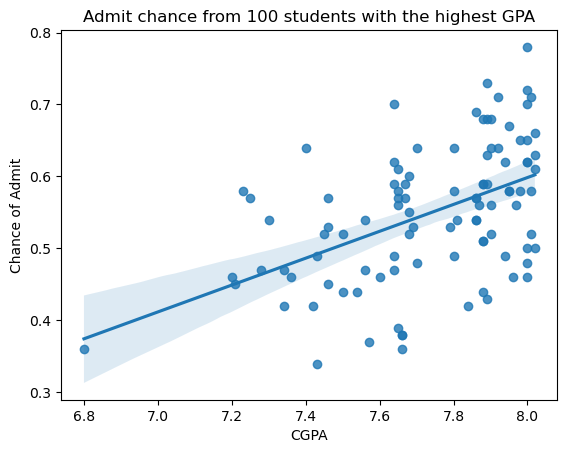

In [24]:
# sns 플롯을 사용해서 아래와 같이 만들기 (학점 하위 100명)

fig = sns.regplot(x="CGPA", y="Chance of Admit", data=data_predict.sort_values(by="CGPA", ascending=True).head(100))
plt.title("Admit chance from 100 students with the highest GPA")
plt.show()

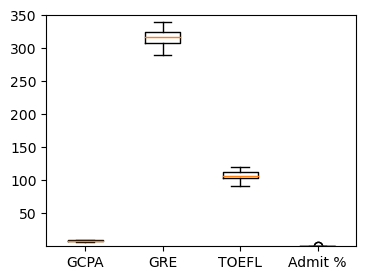

In [26]:
# 뭐가 문제인지 - 각 x값마다 y축 범위 차이

plt.style.use('default')
plt.rcParams['figure.figsize'] = (4, 3)
plt.rcParams['font.size'] = 10

fig, ax1 = plt.subplots()

# boxplt -> 중간값(선), 상위25%(박스), 하위 25%(박스) 표시 -> 박스 크기가 크면 편차 크다
ax1.boxplot([data_predict['CGPA'], data_predict['GRE Score'], data_predict['TOEFL Score'], data_predict['Chance of Admit']])

ax1.set_ylim(0.2, 350.0)

plt.xticks([1, 2, 3, 4], ['GCPA', 'GRE', 'TOEFL', 'Admit %'])

plt.show()

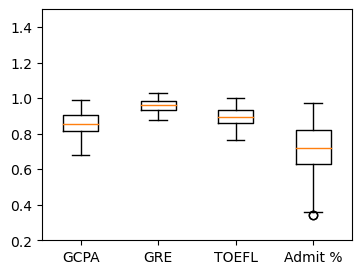

In [27]:
# 해결 - 백분율 변환

plt.style.use('default')
plt.rcParams['figure.figsize'] = (4, 3)
plt.rcParams['font.size'] = 10

fig, ax1 = plt.subplots()

# boxplt -> 중간값(선), 상위25%(박스), 하위 25%(박스) 표시 -> 박스 크기가 크면 편차 크다
ax1.boxplot([data_predict['CGPA']/10, data_predict['GRE Score']/330, data_predict['TOEFL Score']/120, data_predict['Chance of Admit']/1.0])

ax1.set_ylim(0.2, 1.5)

plt.xticks([1, 2, 3, 4], ['GCPA', 'GRE', 'TOEFL', 'Admit %'])

plt.show()

In [36]:
from sklearn.linear_model import LinearRegression

data_predict = pd.read_csv('Admission_Predict_Ver1.1.csv')

dataX = data_predict.drop(['Serial No.', 'Chance of Admit'], axis=1)

dataY = data_predict['Chance of Admit']


# 머신러닝 학습을 위한 데이터 구분
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.25, random_state=0)

# X_train --> gre 같은 변수 사용 데이터
# X_test --> gre 같은 변수 검증 데이터
# y_train --> 합격률 사용 데이터
# y_test --> 합격률 검증 데이터
# test_size = 0.25 --> 사용, 검증 데이터 비율 4 :1로 나눔



# 학습

results = LinearRegression().fit(X_train, y_train)

print("훈련 세트 점수 : {:.2f}".format(results.score(X_train, y_train)))
print("테스트 세트 점수 : {:.2f}".format(results.score(X_test, y_test)))

훈련 세트 점수 : 0.83
테스트 세트 점수 : 0.80


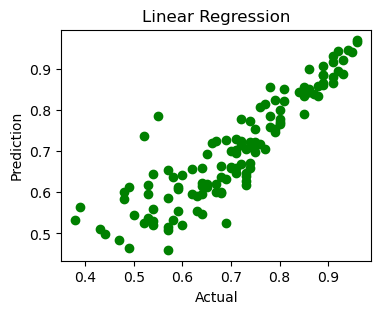

In [37]:
ypred = results.predict(X_test)

plt.scatter(y_test, ypred, color = 'green')

plt.title('Linear Regression')
plt.xlabel('Actual')
plt.ylabel('Prediction')

plt.show()

In [41]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import time

# 브라우저 실행
driver = webdriver.Chrome()
driver.get("https://www.youtube.com/")
titles = driver.find_elements(By.ID, "video-title")
time.sleep(5)

print(titles)

for title in titles:
    print(title.tag_name) # 태그 이름 가져오기
    print(title.text) # inner HTML 값 가져오기
    print(title.get_attribute("aria-label")) # 속성값 가져오기

[<selenium.webdriver.remote.webelement.WebElement (session="cf31c421650933c8e41fc82d30d046b4", element="9DE724FB31E1F7314A6699AE1FF7BC55_element_17")>, <selenium.webdriver.remote.webelement.WebElement (session="cf31c421650933c8e41fc82d30d046b4", element="9DE724FB31E1F7314A6699AE1FF7BC55_element_18")>, <selenium.webdriver.remote.webelement.WebElement (session="cf31c421650933c8e41fc82d30d046b4", element="9DE724FB31E1F7314A6699AE1FF7BC55_element_19")>, <selenium.webdriver.remote.webelement.WebElement (session="cf31c421650933c8e41fc82d30d046b4", element="9DE724FB31E1F7314A6699AE1FF7BC55_element_20")>, <selenium.webdriver.remote.webelement.WebElement (session="cf31c421650933c8e41fc82d30d046b4", element="9DE724FB31E1F7314A6699AE1FF7BC55_element_21")>, <selenium.webdriver.remote.webelement.WebElement (session="cf31c421650933c8e41fc82d30d046b4", element="9DE724FB31E1F7314A6699AE1FF7BC55_element_22")>, <selenium.webdriver.remote.webelement.WebElement (session="cf31c421650933c8e41fc82d30d046b4",

None
span

None
span

None
span

None
span

None
span

None
span

None
yt-formatted-string
캐나다에서 미국 당일치기 여행 - 네덜란드 마을(Lynden), 미국 코스트코 구경하기
캐나다에서 미국 당일치기 여행 - 네덜란드 마을(Lynden), 미국 코스트코 구경하기 게시자: Daniel TV 조회수 680회 3일 전 12분 31초
yt-formatted-string
빈대가 천장을 통해 넘어오네요.. 테이프로 막아도 심각합니다.. (빈대 방역 현장)
빈대가 천장을 통해 넘어오네요.. 테이프로 막아도 심각합니다.. (빈대 방역 현장) 게시자: 코코보라 조회수 336,238회 1일 전 4분 53초
yt-formatted-string
※울컥 주의※ 힘들 때 희망과 용기를 줬던 🔥심장 강타 곡🔥 74호 가수의 '질풍가도(쾌걸 근육맨 2세 OST)'｜싱어게인3｜JTBC 231109 방송 외
※울컥 주의※ 힘들 때 희망과 용기를 줬던 🔥심장 강타 곡🔥 74호 가수의 '질풍가도(쾌걸 근육맨 2세 OST)'｜싱어게인3｜JTBC 231109 방송 외 게시자: JTBC Voyage 조회수 1,593,842회 15시간 전 9분 28초
yt-formatted-string
＂그냥 예뻐요＂ 첫 소절에 임재범을 놀라게 한 ✨17살 소년만의 감성✨ 31호 가수의 '내게 사랑은 너무 써'｜싱어게인3｜JTBC 231109 방송 외
＂그냥 예뻐요＂ 첫 소절에 임재범을 놀라게 한 ✨17살 소년만의 감성✨ 31호 가수의 '내게 사랑은 너무 써'｜싱어게인3｜JTBC 231109 방송 외 게시자: JTBC Voyage 조회수 354,451회 15시간 전 9분 58초
yt-formatted-string

＂감히 심사를...＂ 목소리에서 국악기 소리가?!😮💥 50년 묵은 듯한 내공이 느껴진 25호 가수의 '님은 먼 곳에'｜싱어게인3｜JTBC 231109 방송 외 게시자: JTBC Voyage 조회수 315,894회 15시간 전 8분 5

In [39]:
!pip install selenium

  Obtaining dependency information for selenium from https://files.pythonhosted.org/packages/0e/59/aae37fa93e2d4292c3148efcc3066c8ecfe5cfaa72bf8c0b1a5614622cf7/selenium-4.15.2-py3-none-any.whl.metadata
  Obtaining dependency information for trio~=0.17 from https://files.pythonhosted.org/packages/39/46/620fbe56f41fa3ccdda2136d947fb9bacce3d1eb163f057f0262a0ddf5e0/trio-0.23.1-py3-none-any.whl.metadata
  Obtaining dependency information for trio-websocket~=0.9 from https://files.pythonhosted.org/packages/48/be/a9ae5f50cad5b6f85bd2574c2c923730098530096e170c1ce7452394d7aa/trio_websocket-0.11.1-py3-none-any.whl.metadata
  Obtaining dependency information for outcome from https://files.pythonhosted.org/packages/55/8b/5ab7257531a5d830fc8000c476e63c935488d74609b50f9384a643ec0a62/outcome-1.3.0.post0-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/58.3 kB ? eta -:--:--
     ---------------------------------------- 58.3/58.3 kB 1.5 MB/s eta 0:00:00
   ---------------

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
import pandas as pd

# 브라우저 실행
driver = webdriver.Chrome()

# 네이버 웹툰 페이지 접속
driver.get("https://comic.naver.com/webtoon/weekday")
time.sleep(3)
webtoon_titles = driver.find_elements(By.CLASS_NAME, 'text')
title_list = []

for name in webtoon_titles:
    title_list.append(name.text)
#     print(name.text)
# print(len(webtoon_titles))


# 아래의 출력된 결과를 pandas 라이브러리를 사용해서 csv에 결과 저장
df = pd.series(title_list)
df.to_csv("webtoon.csv")